# Train Camera Parameters

In [1]:
from collections import namedtuple
from IPython.display import display

import numpy as np


import matplotlib.pyplot as plt

import torch
import source.tensorize as t
import torch.optim as optim 
import torch.nn.functional as F
from source.scene import *
from source.renderer import *

%load_ext autoreload
%autoreload 2

### Ground Truth and Initial Guess

Remember the trainable quantities are the scene parameters.  

In [32]:
experiment = 'camera_test_1'
true_scene = parse_scene('./scenes/%s.ground_truth.yaml' % experiment)
pred_scene = parse_scene('./scenes/%s.init1.yaml' % experiment)


Now create the images and display the initialization:

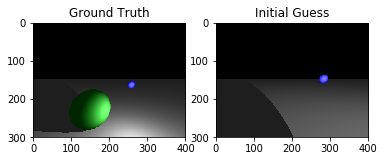

Ground Truth parameters: pos=[-1.5 -1.5 -4. ]
Initial guess parameters: pos=[-0.04826199  0.13661128 -0.42158914]


In [37]:
true_renderer = PhongRenderer(true_scene)
true_image = true_renderer.forward()
true_image.show_image('albedo', title='Ground Truth', subplot='121')

pred_renderer = PhongRenderer(pred_scene)
pred_renderer.set_trainable({'camera': ['position']})
pred_image = pred_renderer.forward()
pred_image.show_image('albedo', title='Initial Guess', subplot='122')
plt.show()
          
print("Ground Truth parameters: pos={0}".format(t.detach_numpy(true_renderer.camera['position'])))
print("Initial guess parameters: pos={0}".format(t.detach_numpy(pred_renderer.camera['position'])))

### Todo: A smart loss function for the camera parameters...

In [38]:
params  = list(filter(lambda p: p.requires_grad, pred_renderer.parameters()))
print(params)
optimizer = optim.Adam(params, lr=0.001)

[Parameter containing:
tensor([-0.0483,  0.1366, -0.4216], requires_grad=True)]


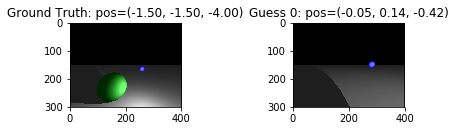

KeyboardInterrupt: 

In [39]:
iterations = 10000
loss_history = []
radius_history = []
for _ in range(iterations):
    
    pred_renderer.clear()
    optimizer.zero_grad()
    
    pred_image = pred_renderer.forward()
    loss = F.l1_loss(true_image.get_image('albedo'), pred_image.get_image('albedo'))
    loss.backward()
    optimizer.step()

    
    #history of intermediate losses and images 
    loss_history.append(t.detach_numpy(loss))
    
    if _ % (iterations/10) == 0:
        true_pos = t.detach_numpy(true_renderer.camera['position'])
        pred_pos = t.detach_numpy(pred_renderer.camera['position'])

        true_image.show_image('albedo',title='Ground Truth: pos=({0:.2f}, {1:.2f}, {2:.2f})'
                              .format(true_pos[0], true_pos[1], true_pos[2]), subplot='121')
        pred_image.show_image('albedo',title='Guess {0}: pos=({1:.2f}, {2:.2f}, {3:.2f})'
                              .format(_, pred_pos[0], pred_pos[1], pred_pos[2]), subplot='122')
        plt.subplots_adjust(wspace=1.0)
        plt.show()
    
    
_ = np.arange(iterations)
plt.plot(_, loss_history, label='loss')
plt.xticks(_)
plt.legend()
plt.show()


In [ ]:
true_image.show_image(title='Ground Truth:', subplot='121')
pred_image.show_image(title='Final Guess:', subplot='122')
plt.show()
print("Ground Truth parameters: fov=%.1f, focal length=%.1f"
      % (true_scene['camera'].field_of_view, true_scene['camera'].focal_length))
fov = t.detach_numpy(pred_renderer.camera['field_of_view'])
focal_length = t.detach_numpy(pred_renderer.camera['focal_length'])
print("Final guess parameters: fov=%.1f, focal length=%.1f"% (fov, focal_length))
